With this notebook we will dig a bit into numpy, learn how to do plots, and perform simple analysis of the output of a numerical simulation.

# Load packages and data

In [1]:
import numpy as np
import matplotlib.pylab as plt #matplotlib is the plotting package
from scipy.optimize import curve_fit #import one single function in a package

Loading data from the simulation, names are quite clear but for the last one.

`type_part` indicates the type of the particle, `0` are DM particles and `1` are stellar particles.

In [2]:
pos_sim = np.load('/Users/hugo/Documents/Teaching/Python_For_Astronomy/Simulation/data/position_pc.npy')
vel_sim = np.load('/Users/hugo/Documents/Teaching/Python_For_Astronomy/Simulation/data/velocity_kms.npy')
age_sim = np.load('/Users/hugo/Documents/Teaching/Python_For_Astronomy/Simulation/data/age_Myr.npy')
mass_sim = np.load('/Users/hugo/Documents/Teaching/Python_For_Astronomy/Simulation/data/mass_msun.npy')
type_part_sim = np.load('/Users/hugo/Documents/Teaching/Python_For_Astronomy/Simulation/data/type.npy')

When you have arrays, it's always good to inspect them to understand their shape, what kind of data they contain etc...

In [3]:
pos_sim

array([[-29017.34824472,  -6462.10105596, -29100.81635854],
       [-25898.45049856, -14043.47502367, -24214.45389858],
       [-49418.60048921,  -4633.86796384, -43974.42823958],
       ...,
       [ 28185.22821878,    550.42841265, -23841.88242898],
       [ 16456.72469074, -11909.75413857, -23821.31433262],
       [ 19921.62505816, -18096.45455016, -23812.89862295]])

In [4]:
pos_sim.shape

(383069, 3)

In [5]:
vel_sim.shape

(383069, 3)

In [6]:
age_sim

array([0., 0., 0., ..., 0., 0., 0.])

In [7]:
age_sim.shape

(383069,)

In [8]:
age_sim.min()

-1598.8936369032342

In [9]:
age_sim.max()

486.9145907913017

In [10]:
mass_sim.shape

(383069,)

In [12]:
type_part_sim

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
np.unique(type_part_sim)

array([0., 1.])

# The case of DM

we want to focus on DM now, we will *filter* our arrays

In [14]:
filt = type_part_sim == 0

In [15]:
filt

array([ True,  True,  True, ...,  True,  True,  True])

In [16]:
pos = pos_sim[filt, :]
vel = vel_sim[filt, :]
age = age_sim[filt]
mass = mass_sim[filt]

In [17]:
pos.shape

(196655, 3)

The size has decreased because we removed stars, you will deal with them later.

## Shape of the DM profile

We will use the basic `plt.plot` function to have a first look at the density profile. You can read the doc online or by hitting `??`

Text(0, 0.5, 'z [pc]')

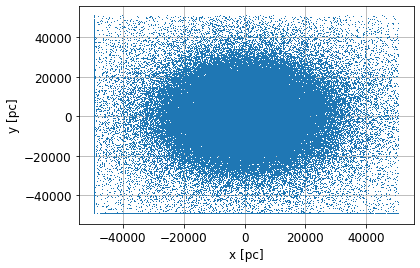

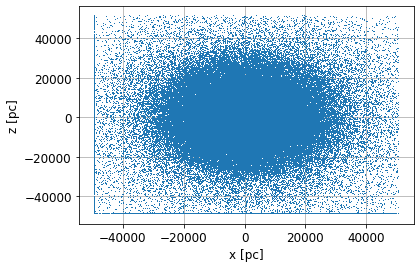

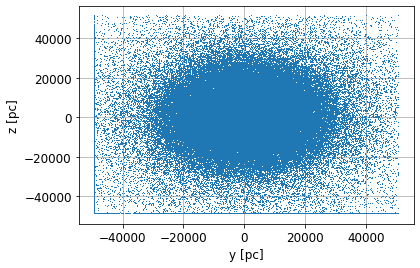

In [14]:
plt.figure() #opens a figure (noxt mandatory)

plt.plot(pos[:, 0], pos[:, 1], linestyle='', marker=',')
plt.xlabel('x [pc]') #set the label
plt.ylabel('y [pc]')

plt.figure()
plt.plot(pos[:, 0], pos[:, 2], linestyle='', marker=',')
plt.xlabel('x [pc]')
plt.ylabel('z [pc]')

plt.figure()
plt.plot(pos[:, 1], pos[:, 2], linestyle='', marker=',')
plt.xlabel('y [pc]')
plt.ylabel('z [pc]')

It seems that the density profile of DM is independant of the viewing angle: it is spherical!

## From cartesian to spherical

Cartesian coordinates are not very adapted, we may want to describe the position of a particle by its distance to the center:

$$r=\sqrt{x^2+y^2+z^2}$$

This is straightforward in Python, thanks to the numpy package.

In [15]:
r = (pos[:, 0]**2 + pos[:, 1]**2 + pos[:, 2]**2)**0.5

As this kind of sum over one dimension (an *axis* in numpy) is frequent, there is built-in function, and one could simply use the following:

In [16]:
r = np.sum(pos**2, axis=1)**.5

We can check that they give the same answer

In [17]:
check = (np.sum(pos**2, axis=1)**.5) == ((pos[:, 0]**2 + pos[:, 1]**2 + pos[:, 2]**2)**0.5)

In [18]:
check

array([ True,  True,  True, ...,  True,  True,  True])

Comparison is made element-wise

In [19]:
False in (np.sum(pos**2, axis=1)**.5) == ((pos[:, 0]**2 + pos[:, 1]**2 + pos[:, 2]**2)**0.5)

False

or simply use the built-in  function `np.array_equal`

In [20]:
np.array_equal( np.sum(pos**2, axis=1)**.5 , (pos[:, 0]**2 + pos[:, 1]**2 + pos[:, 2]**2)**0.5 )

True

There are many built-in functions, you will learn them while you use Python on a daily basis. This said, as usual, check online if what you need already exists or not!

## Density profile

Watch lecture

Text(0, 0.5, '$\\rho$ [M$_\\odot$ pc$^{-3}$]')

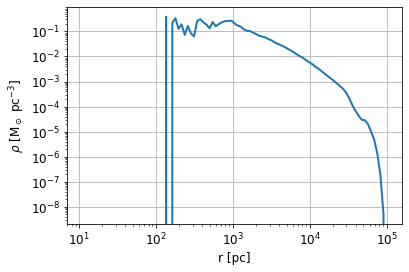

In [21]:
bin_r = np.logspace(1,5, 100) #note the np.logspace call
 
rho, bin_r = np.histogram(r, weights=mass, bins=bin_r) #note the np.histogram call
rho /= np.diff(4/3*np.pi*bin_r**3) #note the np.diff call

plt.loglog(bin_r[1:], rho)
plt.xlabel('r [pc]')
plt.ylabel('$\\rho$ [M$_\\odot$ pc$^{-3}$]')

Most halos can be fitted with a Navarro Frenk and White (NFW) profile (see [wikipedia](https://en.wikipedia.org/wiki/Navarro%E2%80%93Frenk%E2%80%93White_profile)) is it the case for this one? can we infer the two parameters ($\rho_0$ and $r_s$)?

Interlude on numerical fitting

In [22]:
curve_fit?

In [23]:
#define the functional to fit
def NFW(r, rho0, rs):
    return rho0/(r/rs * (1+ r/rs)**2)

We also want to exclude ``bad'' numerical values, that is when the density is 0, or at large radii

In [24]:
filt = (rho > 0) & (bin_r[1:] < 3e4) & ((bin_r[1:] >500))

Let's see what we want to fit

Text(0, 0.5, '$\\rho$ [Msun/pc**3]')

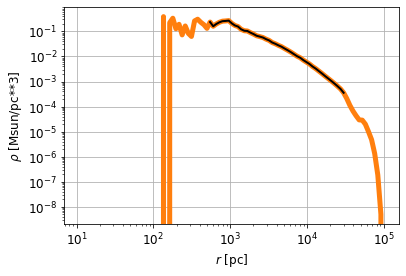

In [25]:
plt.loglog(bin_r[1:], rho, linewidth=5, color='C1') #note the linewidth and the color
plt.loglog(bin_r[1:][filt], rho[filt], linestyle='-', color='k')
plt.xlabel('$r$ [pc]')
plt.ylabel('$\\rho$ [Msun/pc**3]')

In [26]:
#fitting is here
popt,pcov = curve_fit(NFW, bin_r[1:][filt], rho[filt])

In [27]:
#fitting is here
popt,pcov = curve_fit(NFW, bin_r[1:][filt], rho[filt], maxfev=10000)

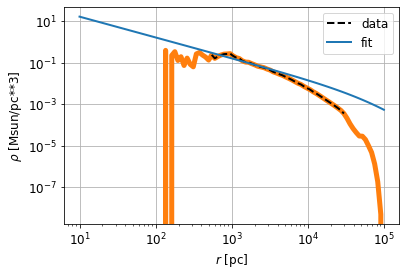

In [28]:
plt.loglog(bin_r[1:], rho, linewidth=5, color='C1')
plt.loglog(bin_r[1:][filt], rho[filt], linestyle='--', color='k', label='data') #note the label and the linestyle

plt.loglog(bin_r, (NFW(bin_r, popt[0], popt[1])), label='fit')

plt.xlabel('$r$ [pc]')
plt.ylabel('$\\rho$ [Msun/pc**3]')
plt.legend() #plt.legend show legend

This is pretty bad, **low** values are not well fitted, can we understand why?

In [29]:
def log_NFW(r, rho0, rs):
    return np.log(NFW(r, rho0, rs))

/var/folders/92/ql9w4tl17rz_6rm9c8y9_wg40000gn/T/ipykernel_62481/409551447.py:8: RuntimeWarning: divide by zero encountered in log
  popt,pcov = curve_fit(log_NFW, bin_r[1:][filt], np.log(rho)[filt], maxfev=10000)
/var/folders/92/ql9w4tl17rz_6rm9c8y9_wg40000gn/T/ipykernel_62481/2810255133.py:2: RuntimeWarning: invalid value encountered in log
  return np.log(NFW(r, rho0, rs))


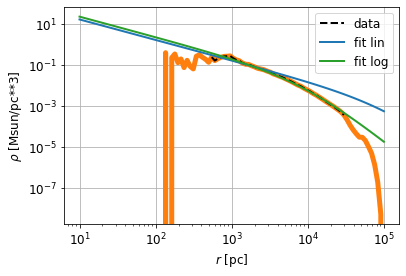

In [30]:
plt.loglog(bin_r[1:], rho, linewidth=5, color='C1')
plt.loglog(bin_r[1:][filt], rho[filt], linestyle='--', color='k', label='data')

popt,pcov = curve_fit(NFW, bin_r[1:][filt], rho[filt], maxfev=10000)
plt.loglog(bin_r, (NFW(bin_r, popt[0], popt[1])), label='fit lin')

#fitting with log is here
popt,pcov = curve_fit(log_NFW, bin_r[1:][filt], np.log(rho)[filt], maxfev=10000)
plt.loglog(bin_r, np.exp(log_NFW(bin_r, popt[0], popt[1])), label='fit log', color='C2')

plt.xlabel('$r$ [pc]')
plt.ylabel('$\\rho$ [Msun/pc**3]')
plt.legend()

## Nice viewing

In [31]:
def show_projection(pos, mass, axis='z', width=50e3):
    '''
    Make a projection plot.
    pos : 3D array of position
    m : 1D array with mass
    axis ('z') : axis to project
    width [in pc] : size of the image
    '''
    
    #create the binning x and y array
    #note that x and y are not necessarily the same
    #as the coordinates, e.g. they are x and z if we 
    #plot on the y axis
    bin_x = bin_y = np.linspace(-width, width, 100)
    
    #keep only the dimensions of interest for us
    if axis == 'x':
        pos = np.take(pos, [1,2], axis=1)
        xlabel = 'y [pc]'
        ylabel = 'z [pc]'
    if axis == 'y':
        pos = np.take(pos, [0,2], axis=1)
        xlabel = 'x [pc]'
        ylabel = 'z [pc]'
    if axis == 'z':
        pos = np.take(pos, [0,1], axis=1)
        xlabel = 'x [pc]'
        ylabel = 'y [pc]'
    
    #make the 2D histogram
    rho, bin_x, bin_y = np.histogram2d(pos[:, 0], pos[:,1], bins=(bin_x, bin_y), weights=mass)

    #plot
    plt.pcolor(bin_x, bin_y, np.log10(rho.T))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return

In [32]:
#reload data
filt = type_part_sim == 0

pos = pos_sim[filt, :]
vel = vel_sim[filt, :]
age = age_sim[filt]
mass = mass_sim[filt]

/var/folders/92/ql9w4tl17rz_6rm9c8y9_wg40000gn/T/ipykernel_62481/3784139651.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.pcolor(bin_x, bin_y, np.log10(rho.T))


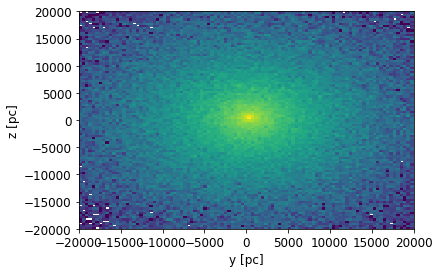

In [33]:
show_projection(pos, mass, axis='x', width=20e3)

/var/folders/92/ql9w4tl17rz_6rm9c8y9_wg40000gn/T/ipykernel_62481/3784139651.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.pcolor(bin_x, bin_y, np.log10(rho.T))


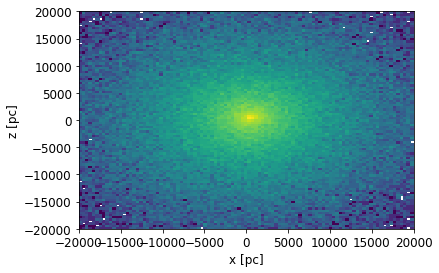

In [34]:
show_projection(pos, mass, axis='y', width=20e3)

/var/folders/92/ql9w4tl17rz_6rm9c8y9_wg40000gn/T/ipykernel_62481/3784139651.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.pcolor(bin_x, bin_y, np.log10(rho.T))


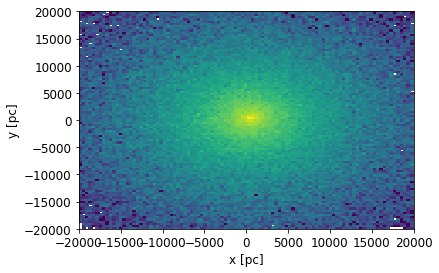

In [35]:
show_projection(pos, mass, axis='z', width=20e3)

# The case of stars (exercice)

Now is your turn to play with the data and understand the stellar structure of this galaxy!

- Understand what is the shape of the stellar density profile
- Compute the **surface** stellar density profile of the galaxy as seen face-on ($\Sigma$)
- Fit $\Sigma$ with a Sersic profile (see [wikipedia](https://en.wikipedia.org/wiki/Sersic_profile)) to obtain the effective radius ($R_e$) and the Sersic index ($n$)

If you have time, you can adress the following:
- Estimate the total mass of the galaxy
- Understand if the galaxy is rotating (counter)clockwise
- Compute the evolution of the star formation rate corresponding, i.e. the mass of stars formed per unit time VS time.